**Purpose**: This document explore `KMeans()` and `MiniBatchKmeans()` in Python.

**Author**: Stephanie Hicks, Shenzhi Shi

**Date**: July 25, 2018

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd

#kmeans
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import datasets

#h5py
import h5py

iris = datasets.load_iris()
X = iris.data
y = iris.target

/Users/Diamond/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#writing the iris dataset into an hdf5 file
file = h5py.File("iris_data.h5", 'w') #creating file object in write mode
#add compressed iris dataset to the file. In this case, we will chunk by rows, since the samples are along the rows
file.create_dataset("iris", data = X, chunks = (1,X.shape[1]), compression = "gzip")
file.close() #close file

In [3]:
#reads in one sample(also one chunk) from the dataset and prints it
with h5py.File("iris_data.h5", 'r') as f:
    print(f.get('iris')[0,:])
    f.close()

#can also do this
f = h5py.File("iris_data.h5", 'r')
print(f.get('iris')[1,:])
f.close()

[5.1 3.5 1.4 0.2]
[4.9 3.  1.4 0.2]


Next we try KMeans on the Iris dataset. This classic implementation of the clustering method based on the Lloyd’s algorithm. It consumes the whole set of input data at each iteration.

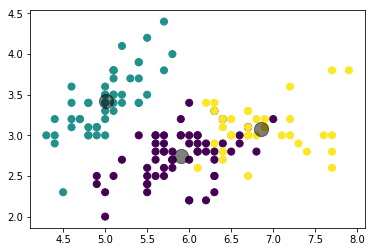

In [4]:
f = h5py.File("iris_data.h5", 'r') #load hdf5 file
X = f.get('iris') #get iris dataset
km = KMeans(n_clusters = 3)
km.fit(X) # fitting the input data
labels = km.predict(X) # getting cluster labels

centroids = km.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis'); 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5);
f.close() #close hdf5 file. 

#Note: If we call f.close() before we run fit on X, there will be an error because the dataset isn't in memory anymore

Next we try [`MiniBatchKMeans()`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) in sklearn. The idea is to [effectively deal with large data](http://scikit-learn.org/stable/modules/scaling_strategies.html), we break the [data into chunks and process](https://adventuresindatascience.wordpress.com/2014/12/30/minibatch-learning-for-large-scale-data-using-scikit-learn/) sequentially (minibatch learning or [online learning](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)). This algorithm uses stochastic gradient descent (SGD), which overcomes the problem of usual gradient-descent-based methods that require all the data to be loaded into memory at once. 

If we want to use the SGD methods for estimation, we want to use the `partial_fit()` function instead of the `fit()` function used above for `KMeans()`. You can break a large dataset into many chunks, successively execute `partial_fit()` on each chunk, then throw the chunk out of memory so the next one can be loaded. 

Inside the `MiniBatchKMeans()` function, the `batch_size` argument controls the size of the mini batches (default = 100). 



In [76]:
f = h5py.File("iris_data.h5", 'r') #load hdf5 file
X = f.get('iris') #get iris dataset
mbkm = MiniBatchKMeans(n_clusters = 3, batch_size=(10*(i+1)))
mbkm.partial_fit(X) # fitting the input data

centroids = mbkm.cluster_centers_
print(centroids[:,0])

cen = [centroids[0,0],centroids[1,0],centroids[2,0]]
c = [0]*3  
colorcodes = ['#ff00ff','#00ffff','#ffff00']
    
#centers sorted by x value
for j in range(3):
    for k in [0, 1]:
        if (cen[k]>cen[k+1]):
            t = cen[k]
            cen[k] = cen[k+1]
            cen[k+1] = t
for j in range(len(cen)):
    for k in range(len(centroids[:,0])):
        if cen[j] == centroids[k,0]:
            c[j] = k
print(centroids[:,0])
print(cen)
print(c)
f.close()

[5.92459016 5.00576923 6.88648649]
[5.92459016 5.00576923 6.88648649]
[5.005769230769231, 5.924590163934426, 6.886486486486486]
[1, 0, 2]


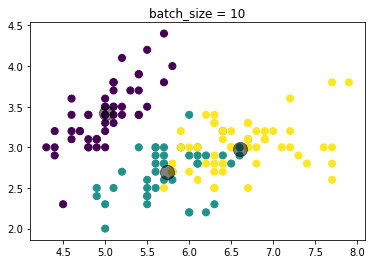

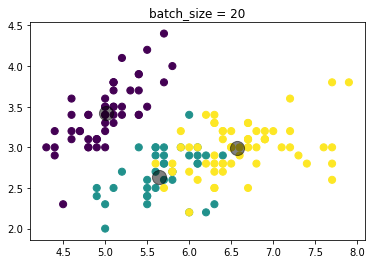

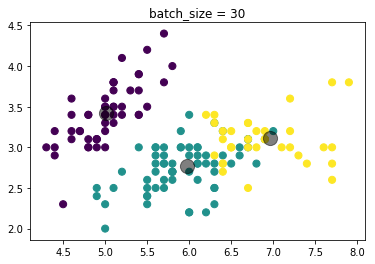

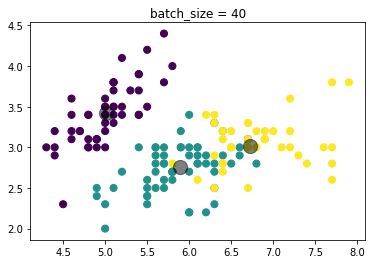

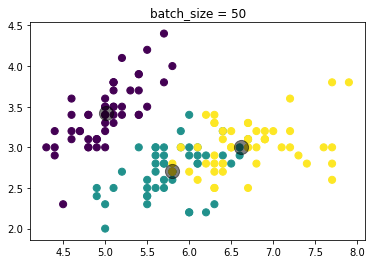

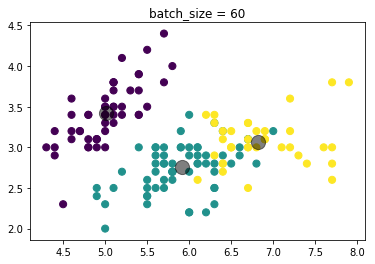

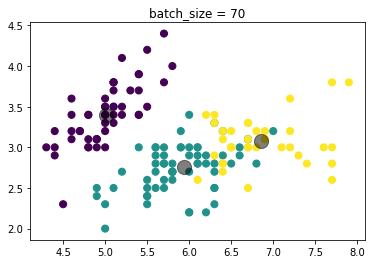

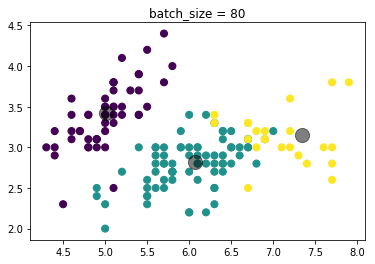

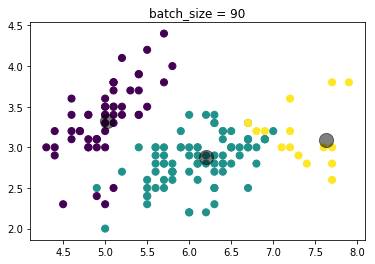

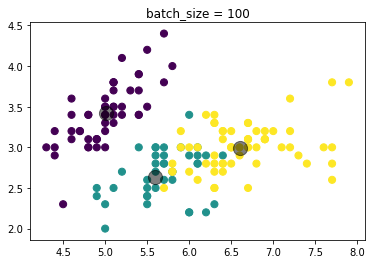

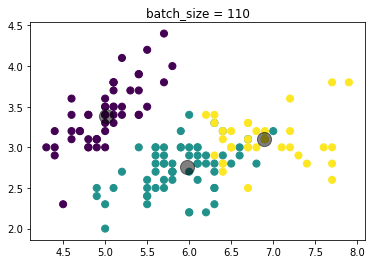

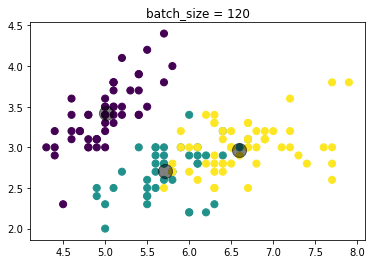

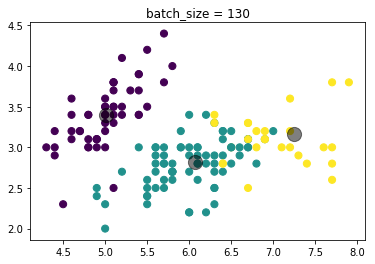

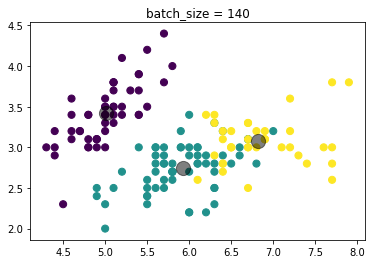

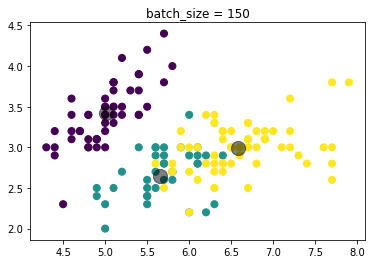

In [85]:
f = h5py.File("iris_data.h5", 'r') #load hdf5 file
X = f.get('iris') #get iris dataset

for i in range(15):
    mbkm = MiniBatchKMeans(n_clusters = 3, batch_size=(10*(i+1)))
    mbkm.partial_fit(X) # fitting the input data
    labels = mbkm.predict(X) # getting cluster labels
    
    centroids = mbkm.cluster_centers_
    
    cen = [centroids[0,0],centroids[1,0],centroids[2,0]]
    c = [0]*3  
    colorcodes = ['#ff00ff','#00ffff','#ffff00']
    
    #sets color order by x position of centers
    for j in range(3):
        for k in [0, 1]:
            if (cen[k]>cen[k+1]):
                t = cen[k]
                cen[k] = cen[k+1]
                cen[k+1] = t
    for j in range(len(cen)):
        for k in range(len(centroids[:,0])):
            if cen[j] == centroids[k,0]:
                c[j] = k
    for j in range(len(labels)):
            if labels[j] == c[0]:
                labels[j] = 0
            else:
                if labels[j] == c[1]:
                    labels[j] = 1
                else:
                    if labels[j] == c[2]:
                        labels[j] = 2
        
    
    plt.figure(i)
    plt.title("batch_size = "+str(10*(i+1)))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis'); 
    plt.scatter(mbkm.cluster_centers_[:, 0], mbkm.cluster_centers_[:, 1], c='black', s=200, alpha=0.5);

f.close() #close hdf5 file

Relevant documents: 



*   Example of using [logistic regression with the the SGD classifer in scikit-learn](https://github.com/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb) and `partial_fit()` function. 
*   Example of using [`MiniBatchKMeans()` with `partial_fit()`](http://nullege.com/codes/search/sklearn.cluster.MiniBatchKMeans.partial_fit)

